In [168]:
import numpy as np
import pandas as pd
import math
from math import sin, cos, radians

import os
import matplotlib.pyplot as plt
import datetime

import scipy.stats as st
import scipy.signal as sgl
pd.set_option('display.max_columns', 500)

#import fastdtw
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

import scipy.interpolate as spi

#hide warning
import warnings
warnings.filterwarnings('ignore')

In [169]:
# file_name='./signature_data_preprocessed/U'+str(i)+'S'+str(j)+'.txt'
prefix = "./dataset/test/"
prefix1 = "./dataset/SUSIG/GENUINE/SESSION1/"
prefix2 = "./dataset/SUSIG/FORGERY/"

# file_name = prefix + '202084182540.sig'
file_name = prefix1 + '004_1_1.sig'
file=pd.read_csv(file_name,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
file_size=len(file)

# file2_name = 'signaturecontent_08191708.sig'
file2_name = prefix + 'verify_2020821123742.sig'
file2=pd.read_csv(file2_name,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
file2_size=len(file2)

# file3_name = prefix + '2020720125531.sig'
# file3_name = prefix + '202084182532.sig'
file3_name = prefix1 + '004_1_5.sig'

file3=pd.read_csv(file3_name,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
file3_size=len(file3)

# file_fake_name = prefix + 'verify_2020821123742.sig'
file_fake_name = prefix2 + '004_f_8.sig'
file_fake=pd.read_csv(file_fake_name,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None, skiprows=2)
file_fake_size=len(file_fake)


file_sigpad_name = prefix + 'sigpad.sig'
file_sigpad=pd.read_csv(file_sigpad_name,delimiter=' ', names=['X','Y','TStamp','Pres','EndPts'], header=None)
file_sigpad_size=len(file_sigpad)

In [170]:
startTime = file['TStamp'][0]
file['TStamp2'] = (file['TStamp'] - startTime) #ms

startTime = file3['TStamp'][0]
file3['TStamp2'] = (file3['TStamp'] - startTime) #ms

startTime = file_fake['TStamp'][0]
file_fake['TStamp2'] = (file_fake['TStamp'] - startTime) #ms

startTime = file_sigpad['TStamp'][0]
file_sigpad['TStamp2'] = (file_sigpad['TStamp'] - startTime) #ms

# file3

In [171]:
startTime = file2['TStamp'][0]
file2['TStamp2'] = (file2['TStamp'] - startTime) #ms

In [172]:
startTime = file3['TStamp'][0]
file3['TStamp2'] = (file3['TStamp'] - startTime) #ms

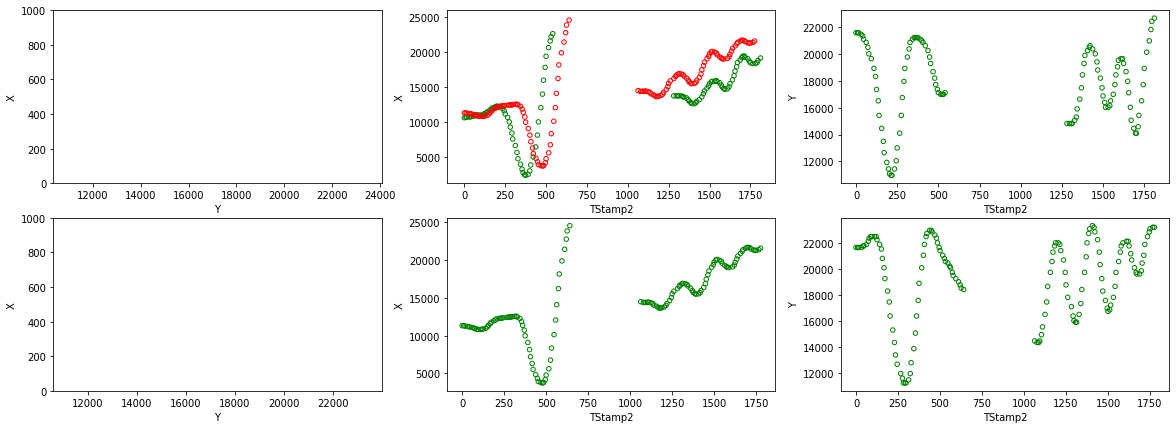

In [173]:
fig = plt.figure(figsize=[20,7])

#整理前的两张图片对比
ax1 = fig.add_subplot(2, 3, 1)
file.plot.scatter(x = "Y", y = "X", ax=ax1, marker='o',c='', edgecolors='g', ylim = (0, 1000))
file3.plot.scatter(x = "Y", y = "X", ax=ax1, marker='o',c='', edgecolors='r', ylim = (0, 1000))
ax2 = fig.add_subplot(2, 3, 2)
file.plot.scatter(x='TStamp2', y='X', ax=ax2, marker='o',c='', edgecolors='g')
file3.plot.scatter(x = "TStamp2", y = "X", ax=ax2, marker='o',c='', edgecolors='r')

ax3 = plt.subplot(2, 3, 3)
file.plot.scatter(x='TStamp2', y='Y', ax=ax3, marker='o',c='', edgecolors='g')

ax4 = fig.add_subplot(2, 3, 4)
file3.plot.scatter(x = "Y", y = "X", ax=ax4, marker='o',c='', edgecolors='g',  ylim = (0, 1000))
ax5 = fig.add_subplot(2, 3, 5)
file3.plot.scatter(x='TStamp2', y='X', ax=ax5, marker='o',c='', edgecolors='g')
ax6 = plt.subplot(2, 3, 6)
file3.plot.scatter(x='TStamp2', y='Y', ax=ax6, marker='o',c='', edgecolors='g')
#可以清晰的发现，扫描的点不够，不能完整反映图片

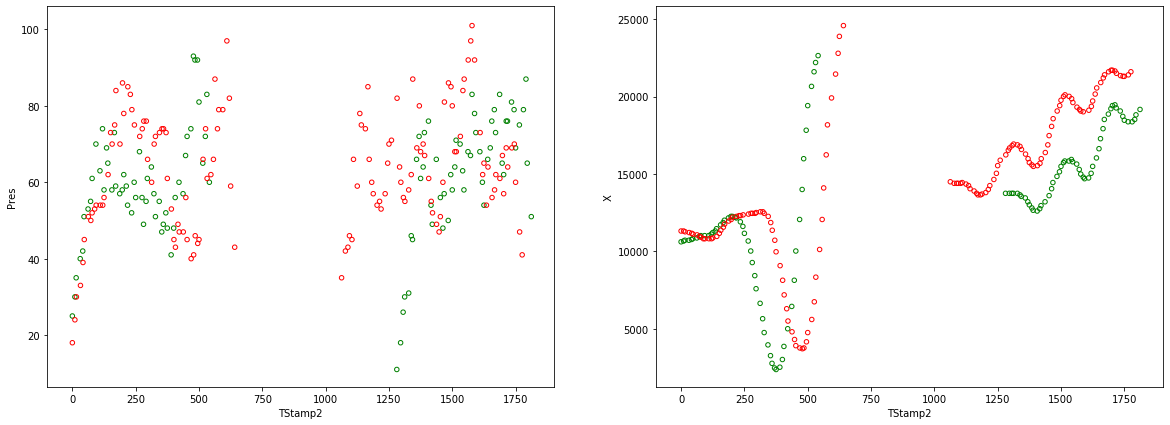

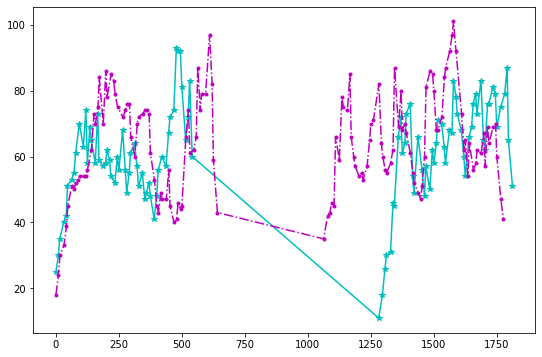

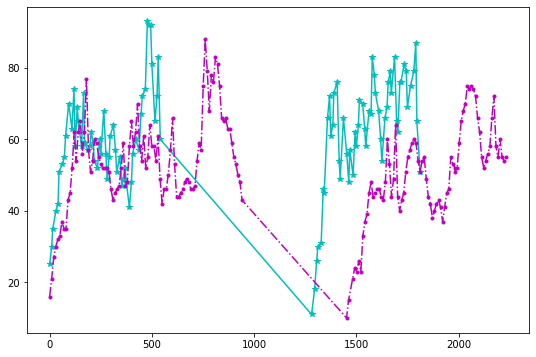

In [174]:
fig = plt.figure(figsize=[20,7])

#整理前的两张图片对比
ax1 = fig.add_subplot(1, 2, 1)
file.plot.scatter(x = "TStamp2", y = "Pres", ax=ax1, marker='o',c='', edgecolors='g')
file3.plot.scatter(x = "TStamp2", y = "Pres", ax=ax1, marker='o',c='', edgecolors='r')

# file3.plot.scatter(x = "Y", y = "X", ax=ax1, marker='o',c='', edgecolors='r', ylim = (0, 1000))

ax2 = fig.add_subplot(1, 2, 2)
file.plot.scatter(x='TStamp2', y='X', ax=ax2, marker='o',c='', edgecolors='g')
file3.plot.scatter(x = "TStamp2", y = "X", ax=ax2, marker='o',c='', edgecolors='r')
fig.show()

fig = plt.figure(figsize=[9,6])
plt.plot(file["TStamp2"], file["Pres"],'c*-', )
plt.plot(file3['TStamp2'], file3['Pres'] , 'm.-.')
fig.show()

fig = plt.figure(figsize=[9,6])
plt.plot(file["TStamp2"], file["Pres"],'c*-', )
plt.plot(file_fake['TStamp2'], file_fake['Pres'] , 'm.-.')
fig.show()
#找pressure的点


In [175]:
## DTW Distance
def d(x,y):
    return np.sum((x-y)**2)

def dtw_distance(s1,s2, mww=10000):

    ts_a = s1
    ts_b = s2
    M, N = np.shape(ts_a)[1], np.shape(ts_b)[1]

    cost = np.ones((M, N))

    # Initialize the first row and column
    cost[0, 0] = d(ts_a[:,0], ts_b[:,0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(ts_a[:,i], ts_b[:,0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(ts_a[:,0], ts_b[:,j])

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - mww), min(N, i + mww)):
            choices = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
            cost[i, j] = min(choices) + d(ts_a[:,i], ts_b[:,j])

    # Return DTW distance given window 
    return cost[-1, -1]



<Figure size 1440x2160 with 0 Axes>

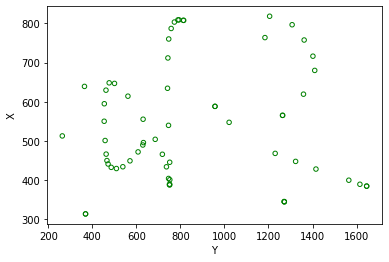

In [176]:
fig = plt.figure(figsize=[20, 30])
file_sigpad.plot.scatter(x='Y', y='X', marker='o',c='', edgecolors='g')

<Figure size 1440x2160 with 0 Axes>

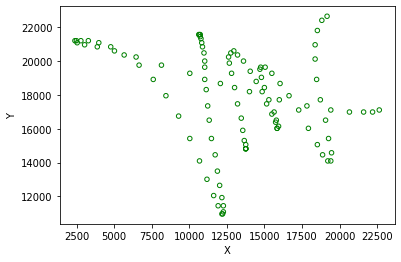

In [177]:
fig = plt.figure(figsize=[20, 30])
file.plot.scatter(x='X', y='Y', marker='o',c='', edgecolors='g')

In [178]:
# ##Preprocessing
# P=[]
# V=[]
# SDX=[]
# SDY=[]
# fileP = file3

# file_size=len(fileP)
# X=fileP['X']
# Y=fileP['Y']
# TS=fileP['TStamp2']
# BS=fileP['EndPts']
# # AZ=file['AZ']
# # AL=file['AL']
# # P=file['P']
# aX=sum(X)/file_size
# aY=sum(Y)/file_size
# for k in range(0,file_size-1):
#     if TS[k]==TS[k+1]:
#         X[k+1]=(X[k]+X[k+1])/2
#         Y[k+1]=(Y[k]+Y[k+1])/2
#         TS[k+1]=(TS[k]+1)
#         BS[k+1]=(BS[k]+BS[k+1])/2
# #         AZ[k+1]=(AZ[k]+AZ[k+1])/2
# #         AL[k+1]=(AL[k]+AL[k+1])/2
# #         P[k+1]=(P[k]+P[k+1])/2
#     if k<file_size-1:
#         V.append(((math.sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2))*(TS[file_size-1]-TS[0]))/(TS[k+1]-TS[k]))
#     SDX.append((X[k]-aX)**2)
#     SDY.append((Y[k]-aY)**2)
# SDX.append((X[file_size-1]-aX)**2)
# SDY.append((Y[file_size-1]-aY)**2)
# V.append(0)


# # data={'X':X,'Y':Y,'TS':TS,'BS':BS,'AZ':AZ,'AL':AL,'P':P,'V':V,'SDX':SDX,'SDY':SDY}
# data={'X':X,'Y':Y,'TStamp2':TS,'EndPts':BS,'P':P,'V':V,'SDX':SDX,'SDY':SDY}

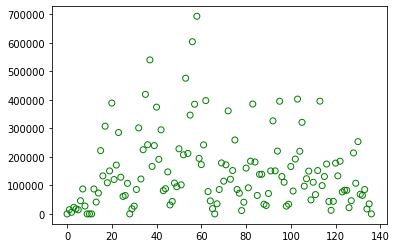

In [179]:
# fig = plt.figure(figsize=[6,4])
# # plt.scatter(x = data["Y"], y = data["V"], marker='o',c='', edgecolors='g')
# plt.scatter(x = list(range(0,len(file3), 1)), y = data["V"], marker='o',c='', edgecolors='g')

# # plt.bar(list(range(0,len(data1), 1)), data['V'])
# # print(data)

<Figure size 1440x2160 with 0 Axes>

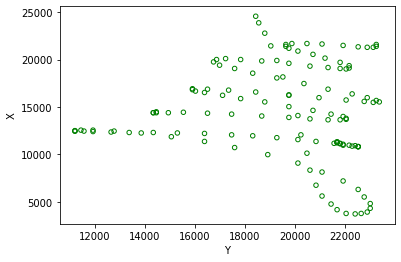

In [180]:
fig = plt.figure(figsize=[20, 30])
file3.plot.scatter(x='Y', y='X', marker='o',c='', edgecolors='g')

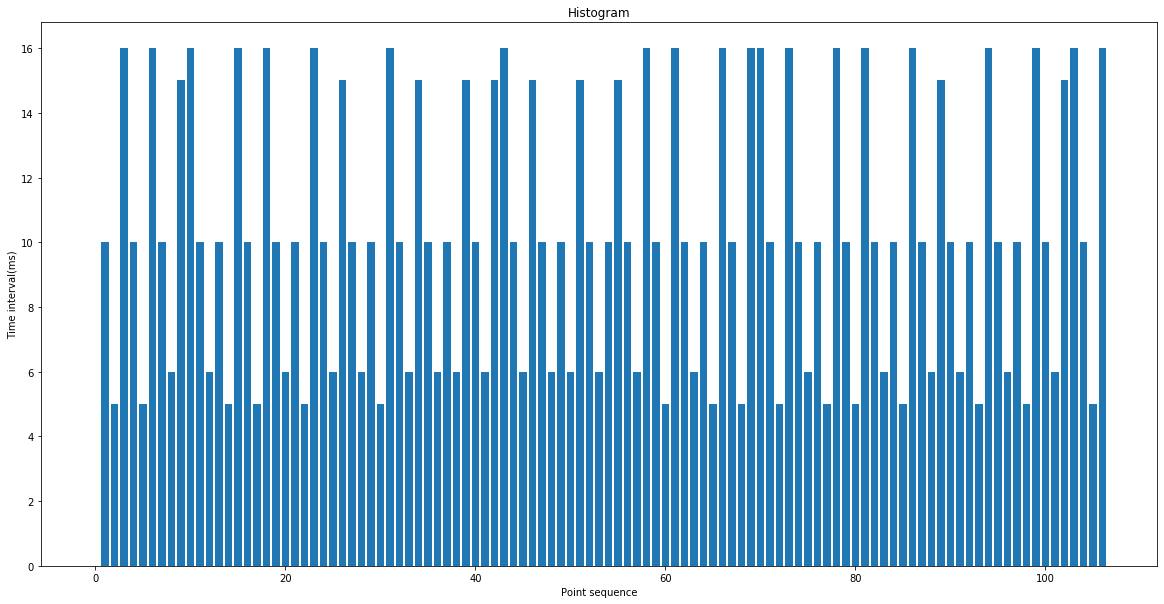

In [181]:
intervals = []
for index, row in file.iterrows():
    if index == 0:
        intervals.append(0)
        continue
#     print(file['TStamp2'][index-1])
    interval = file['TStamp2'][index]-file['TStamp2'][index-1]
    if interval > 300:
        continue
    intervals.append(interval)    
# intervals = np.array(intervals)


fig = plt.figure(figsize=[20, 10])
plt.bar(range(len(intervals)), intervals)

# 显示横轴标签
plt.xlabel("Point sequence")
# 显示纵轴标签
plt.ylabel("Time interval(ms)")
# 显示图标题
plt.title("Histogram")
fig.show() # it is clearly shown that the intervals art not the same.

In [182]:
def remove_duplicated_point(df):
    df_new = df.drop(index=df.index)    
    old_x = df['X'][0]
    old_y = df['Y'][0]
    for index, row in df.iterrows():
        if row['X'] != old_x or row['Y']!=old_y or index == 0:
            df_new.loc[len(df_new)] = {'X': row['X'], 'Y': row['Y'], 'TStamp': row['TStamp'], 'Pres': row['Pres'], 'EndPts': row['EndPts'],
                                       'TStamp2': row['TStamp2']}
            old_x = row['X']
            old_y = row['Y']
        # update the EndPts if the point is   
        elif row['X'] == old_x and row['Y'] == old_y and row['EndPts'] == 1:
            df_new.iloc[len(df_new)-1]['EndPts']  = 1
    return df_new

In [183]:
def cal_acceleration(df):
    acce_arr = []
    for index, row in df.iterrows():
        if index == len(df) - 1:
            acce = 0
        else:    
            dy = df['Y'][index + 1] - row['Y']
            dx = df['X'][index + 1] - row['X']
        acce_arr.append(acce)    
        break

        
def addSigFeature(df):
    dX = derivation(df['X'].tolist())     # dx
    dY = derivation(df['Y'].tolist())     # dy
#     df['dX'] = dX
#     df['dY'] = dY
    Vel = np.zeros(len(df)).tolist()   # velocity
    Angle = np.zeros(len(df)) # angle
    
    
    T = len(df) -1
    t = 1
    while t<= T:
        Vel[t] = math.sqrt(dX[t] * dX[t] + dY[t] * dY[t])
        if dY[t] != 0 and dX[t] != 0:
            Angle[t] = math.atan(dY[t] / dX[t])
        elif dX[t] == 0:
            Angle[t] = math.atan(dY[t] / 0.01)
        else:
            Angle[t] = 0
        t += 1    
    dAngle = derivation(Angle)
    dVel = derivation(Vel)
    Logcr = np.zeros(len(df)).tolist() 
    Tam = np.zeros(len(df)).tolist() #加速度 acceleration
    
    t = 1
    while t<= T:
        Logcr[t] = math.log((abs(Vel[t]) + 0.01) / ((abs(dAngle[t]) + 0.01))) ;
        Tam[t] = math.sqrt(dVel[t] * dVel[t] + Vel[t] * Vel[t] * dAngle[t] * dAngle[t]) ;
        t += 1
    df['Angle'] = Angle
    df['Vel'] = Vel
    df['Logcr'] = Logcr
    df['Tam'] = Tam
    return df
    

    
# calculate the difference of the discrete sequence    
def derivation(signal):
    T = len(signal)-1
    dsignal = np.zeros(len(signal)).tolist()
    dsignal[0] = (2*signal[2] + signal[1] - 3*signal[0]) / 5
    dsignal[1] = (2*signal[3] + signal[2] - 2*signal[1] - signal[0]) / 6
    t= 2
    while t<=T-2:
        dsignal[t] = (2*signal[t+2] + signal[t+1] - signal[t-1] - 2*signal[t-2]) / 10 
#         print(dsignal[t])        
        t += 1
        # (2(Xn+2)+(Xn+1)-(Xn-1)-2(Xn-2))/10 == [2(Xn+2)-2(Xn+1)+3(Xn+1)-3(Xn)+3(Xn)-3(Xn-1)+2(Xn-1)-2(Xn-2)]/10
        
    dsignal[T-1] = (signal[T] - signal[T-2] + 2*signal[T-1] - 2*signal[T-3]) / 6 
    dsignal[T] = (3*signal[T] - signal[T-1] - 2*signal[T-2]) / 5 
    return dsignal
    
# X = Sig(:, 1) ;
# Y = Sig(:, 2) ;
# if pflag
#     P = Sig(:, 3);
# end
# T = length(Sig) ;

# % get the velocity\angle\curvature\full acceleration\coordinates\pressure
# dX = Derivation(X);     % dx
# dY = Derivation(Y);     % dy
# Vel = zeros(size(X));   % velocity
# Angle = zeros(size(X)); % angle
# for t = 1 : T
#     Vel(t) = sqrt(dX(t) * dX(t) + dY(t) * dY(t)) ;
#     if dY(t) ~= 0
#         Angle(t) = atan(dY(t) / dX(t)) ;
#     else
#         Angle(t) = 0 ;
#     end
# end
# dAngle = Derivation(Angle) ;
# dVel = Derivation(Vel) ;
# Logcr = zeros(size(X)) ;
# Tam = zeros(size(X)) ;
# for t = 1 : T
#     Logcr(t) = log((abs(Vel(t)) + 0.01) / ((abs(dAngle(t)) + 0.01))) ;
#     Tam(t) = sqrt(dVel(t) * dVel(t) + Vel(t) * Vel(t) * dAngle(t) * dAngle(t)) ;
# end
# if pflag
#     Feature = [X, Y, P, Angle, Vel, Tam, Logcr] ;
# else
#     Feature = [X, Y, Angle, Vel, Tam, Logcr] ;
# end

# % signal normalization
# Feature = zscore(Feature);
# end


# data1 = addSigFeature(data1)   
# data2 = addSigFeature(data2)   
# data3 = addSigFeature(data3)   

107


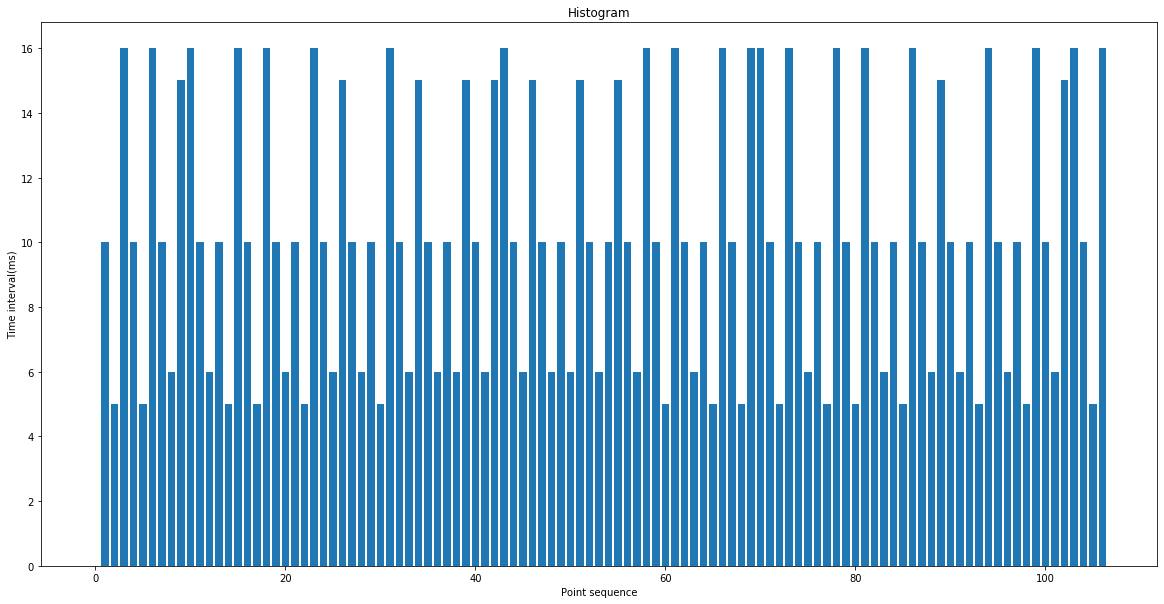

In [184]:
intervals = []
for index, row in file.iterrows():
    if index == 0:
        intervals.append(0)
        continue
#     print(file['TStamp2'][index-1])
    interval = file['TStamp2'][index]-file['TStamp2'][index-1]
    if interval > 300:
        continue
    intervals.append(interval)    
# intervals = np.array(intervals)

print(len(intervals))
fig = plt.figure(figsize=[20, 10])
plt.bar(range(len(intervals)), intervals)

# 显示横轴标签 show x-axis
plt.xlabel("Point sequence")
# 显示纵轴标签 show y-axis
plt.ylabel("Time interval(ms)")
# 显示图标题 show graph title
plt.title("Histogram")
fig.show() # it is clearly shown that the intervals art not the same

In [185]:
# Cubic-Spline to add points in stroke and make the curves smooth
def interpolate_points(df):
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

    # 按手指离开屏幕的点，分笔触差值，因为在笔触间差值没有意义
    # 寻找断点
    EndPts = [0]
    EndPts.extend(list(df.loc[df["EndPts"] == 1].index))
    EndPts_len = len(EndPts)
    if EndPts_len < 2:
        EndPts.append(len(df)-2) #如果没有就设最后一个点为离开屏幕的点
        EndPts_len += 1
    print(EndPts)        
    i = 0
    
    new_x_all = []
    iy3_x_all = []
    iy3_y_all = []
    while i < EndPts_len - 1:
        #data preparation
        start = EndPts[i]
        end = EndPts[i+1] + 1
        if start == 0:
            X= np.array(df['TStamp2'][0:end].tolist())
            Y= np.array(df['X'][0:end].tolist())
            Y2= np.array(df['Y'][0:end].tolist())
            if df['TStamp2'][start+1:end].max() - df['TStamp2'][start+1:end].min() <=15 or end - start <= 6:
                i+=1
                continue            
            new_x=np.arange(0,df['TStamp2'][0:end].max(),15) #define interpolate points
        else:            
            X= np.array(df['TStamp2'][start+1:end].tolist())
            Y= np.array(df['X'][start+1:end].tolist())
            Y2= np.array(df['Y'][start+1:end].tolist())
            if df['TStamp2'][start+1:end].max() - df['TStamp2'][start+1:end].min() <=15 or end - start <= 6:
                i+=1
                continue            
            new_x=np.arange(df['TStamp2'][start+1:end].min(),df['TStamp2'][start+1:end].max(),15) #define interpolate points            

    #     #进行一阶样条插值 Linear spline interpolation
    #     ipo1=spi.splrep(X,Y,k=1,s=10) 
    #     iy1=spi.splev(new_x,ipo1)

        #cubic spline
        ipo3=spi.splrep(X,Y,k=3, s=100) 
        iy3=spi.splev(new_x,ipo3) 
        ipo3_y=spi.splrep(X,Y2,k=3, s=100) 
        iy3_y=spi.splev(new_x,ipo3_y) 
        new_x_all.extend(new_x)
        iy3_x_all.extend(iy3)
        iy3_y_all.extend(iy3_y)
        i += 1

    print(len(iy3_x_all))    
    X_all= np.array(df['TStamp2'].tolist())
    Y_all = np.array(df['X'].tolist())
    Y2_all = np.array(df['Y'].tolist())
    
    ##draw graph
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,12))

    ax1.plot(X_all,Y2_all,'o',label='样本点')
    ax1.plot(new_x_all,iy3_y_all,'*-',label='插值点')
    ax1.set_ylim(Y2_all.min()-20,Y2_all.max()+20)
    ax1.set_ylabel('Y坐标')
    ax1.set_title('Y三次线性插值')
    ax1.legend()

    ax2.plot(X_all,Y_all,'o',label='样本点')
    ax2.plot(new_x_all,iy3_x_all,'*-',label='插值点')
    ax2.set_ylim(Y_all.min()-20,Y_all.max()+20)
    ax2.set_ylabel('X坐标')
    ax2.set_title('X三次样条插值')
    ax2.legend()    
    fig.show()
    
    df_new = df.copy()
    for i, val in enumerate(new_x_all):
        if val in df['TStamp2'].tolist():
            continue
        if val in df['TStamp2'].tolist():
            continue            
        df_new.loc[len(df_new)] = {'X': iy3_x_all[i], 'Y': iy3_y_all[i], 'TStamp': 0, 'Pres': 0, 'EndPts': 0,
                                       'TStamp2': val}
    df_new = df_new.sort_values(by=['TStamp2'])
#     return df_new
    return df
#     df_new = remove_duplicated_point(df_new)
    
#     fig = plt.figure(figsize=[10,6])
#     plt.plot( df_new['TStamp2'], df_new["X"],'c*-')
#     fig.show()
#     fig = plt.figure(figsize=[10,6])
#     plt.plot( df['TStamp2'], df["X"],'c*-')
#     fig.show()    

file = remove_duplicated_point(file) # use RDP algorithm to remove duplicated points
file3 = remove_duplicated_point(file3) # use RDP algorithm to remove duplicated points
file_fake = remove_duplicated_point(file_fake) # use RDP algorithm to remove duplicated points

file = addSigFeature(file) 
file3 = addSigFeature(file3)
file_fake = addSigFeature(file_fake) 
# file = interpolate_points(file)
# file3 = interpolate_points(file3)
# file_fake = interpolate_points(file_fake)




In [186]:
 from decimal import Decimal
def get_gravity_point(points):
    """
    @brief      获取多边形的重心点
    @param      points  The points
    @return     The center of gravity point.
    """
    if len(points) <= 2:
        return list()

    area = Decimal(0.0)
    x, y = Decimal(0.0), Decimal(0.0)
    for i in range(len(points)):
        lng = Decimal(points[i][0].item())
        lat = Decimal(points[i][1].item())
        nextlng = Decimal(points[i-1][0].item())
        nextlat = Decimal(points[i-1][1].item())

        tmp_area = (nextlng*lat - nextlat*lng)/Decimal(2.0)
        area += tmp_area
        x += tmp_area*(lng+nextlng)/Decimal(3.0)
        y += tmp_area*(lat+nextlat)/Decimal(3.0)
    x = x/area
    y = y/area
    return [float(x), float(y)]

In [187]:
# 求两直线夹角
def get_angle_betw_lines(x1, y1, x2, y2, x3, y3, x4, y4):
    k1 = (y2-y1)/(float(x2-x1))
    k2 = (y4-y3)/(float(x4-x3))
    Cobb = math.fabs(np.arctan((k1-k2)/(float(1 + k1*k2)))*180/np.pi)+0.5
    return Cobb


def get_grivity_angle(P):
    points_left = []
    points_right = []
    points_x = []
    points_y = []
    for point in   P.exterior.coords:
        points_x.append(point[0])   
        points_y.append(point[1])    
     
    # In order to prevent abnormal situations, the center point value is too large or too small
    if abs(P.centroid.x) > 50000 or  abs(P.centroid.y) > 50000: 
        center_x = np.mean(points_x)
    else:
        center_x = P.centroid.x
        
    for point in P.exterior.coords:
        if point[0] <= center_x:
            points_left.append([point[0], point[1]])
        else:
            points_right.append([point[0], point[1]])

    P_left = Polygon(points_left)
    P_right = Polygon(points_right)        


#     print(P.centroid)
    theta = get_angle_betw_lines( P_left.centroid.x,  P_left.centroid.y,  P_right.centroid.x,  P_right.centroid.y,      
                                 0,0, 10,0)   
    return theta


#rotate for Polygon
def rotate_polygon(polygon, angle, center_point=(0, 0)):
    """Rotates the given polygon which consists of corners represented as (x,y)
    around center_point (origin by default)
    Rotation is counter-clockwise
    Angle is in degrees
    """
    rotated_polygon = []
    for corner in polygon.exterior.coords:
        rotated_corner = rotate_point(corner, angle, center_point)
        rotated_polygon.append(rotated_corner)
    rotated_polygon = Polygon(rotated_polygon)    
    return rotated_polygon

def rotate_point(point, angle, center_point=(0, 0)):
    """Rotates a point around center_point(origin by default)
    Angle is in degrees.
    Rotation is counter-clockwise
    """
    angle_rad = radians(angle % 360)
    # Shift the point so that center_point becomes the origin
    new_point = (point[0] - center_point[0], point[1] - center_point[1])
    new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
                 new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
    # Reverse the shifting we have done
    new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
    return new_point



# gravity_x, gravity_y = gravity_normalize(file)
# print(gravity_x, gravity_y)

from shapely.geometry import Polygon

def rotate_graphic(file):
    points_left = []
    points_right = []
    points = []

    for index, row in file.iterrows():
        if  abs(row['X']) > 100000 or abs(row['Y']) > 100000:
            continue
        points.append([row['X'], row['Y']])

    
    
    P = Polygon(points)
    print(P.centroid)
    xs, ys = zip(*points) #create lists of x and y values
    xs = list(xs)
    ys = list(ys)
    print(max(xs),min(xs),max(ys),min(ys))
    plt.figure()
    plt.plot(xs,ys)  
    plt.plot(np.mean(xs),np.mean(ys),"rx") 
    
    plt.show() # if you need...
    print(np.mean(xs),np.mean(ys))
    
    
    theta = get_grivity_angle(P)
    theta_old = theta
    print(theta)
    
    
    if theta >6 and get_grivity_angle(rotate_polygon(P, theta_old/24, (P.centroid.x, P.centroid.y))) < theta: 
        while theta > 6.0 :
#             print("here")
    #     if theta <= 90: # clock-wise 顺时针
            P = rotate_polygon(P, theta_old/24, (P.centroid.x, P.centroid.y))        
            theta = get_grivity_angle(P)
    elif  theta >6 and get_grivity_angle(rotate_polygon(P, -theta_old/24, (P.centroid.x, P.centroid.y))) < theta_old:
        while theta > 6.0 :
            P = rotate_polygon(P, -theta_old/24, (P.centroid.x, P.centroid.y))        
            theta = get_grivity_angle(P)          
            
    P_rotated = P
    P_rotated_points_x = []
    P_rotated_points_y = []
    for point in   P_rotated.exterior.coords:
        P_rotated_points_x.append(point[0])   
        P_rotated_points_y.append(point[1])   

#     print(P_rotated.centroid)




    fig = plt.figure(figsize=[6,4])
    plt.scatter(x = file["X"], y = file["Y"], marker='o',c='', edgecolors='g')

#     plt.plot(gravity_y, gravity_x, 'rx')
#     plt.plot(P_left.centroid.y, P_left.centroid.x, 'rx')
#     plt.plot(P_right.centroid.y, P_right.centroid.x, 'rx')

    plt.scatter(x = P_rotated_points_x, y = P_rotated_points_y, marker='o',c='', edgecolors='b')

    points_left = []
    points_right = []
    for point in P_rotated.exterior.coords:
        if point[0] <= P_rotated.centroid.x:
            points_left.append([point[0], point[1]])
        else:
            points_right.append([point[0], point[1]])

    P_left = Polygon(points_left)
    P_right = Polygon(points_right)        
#     plt.plot(P_left.centroid.y, P_left.centroid.x, 'bx')
#     plt.plot(P_right.centroid.y, P_right.centroid.x, 'bx')
    

#     theta = get_angle_betw_lines( P_left.centroid.x,  P_left.centroid.y,  P_right.centroid.x,  P_right.centroid.y,      
#                                  0,0, 10,0)
#     print(theta)
    fig.show()

#     file['X'] = P_rotated_points_x[0:-1]
#     file['Y'] = P_rotated_points_y[0:-1]
    return file

# file = rotate_graphic(file)
# file3 = rotate_graphic(file3)
# file_fake = rotate_graphic(file_fake)

In [188]:
# add columns
file['normalX'] = file['X']
file['normalY'] = file['Y']
file3['normalX'] = file3['X']
file3['normalY'] = file3['Y']
file_fake['normalX'] = file_fake['X']
file_fake['normalY'] = file_fake['Y']

In [189]:
# Size normalization 大小规整
# position normalization 位置规整
def normalizeFile(normalInputFile):
    widthX = 200 #width
    heightY = 500 #height
    minX = normalInputFile['X'].min()
    minY = normalInputFile['Y'].min()
    maxX = normalInputFile['X'].max()
    maxY = normalInputFile['Y'].max()
    normalInputFile['normalX'] = widthX * ((normalInputFile['X'] - minX)/(maxX - minX))
    normalInputFile['normalY'] = heightY * ((normalInputFile['Y'] - minY)/(maxY - minY))
    
    #position normalization
    averX = normalInputFile['normalX'].mean()
    averY = normalInputFile['normalY'].mean()

    normalInputFile['normalX'] = normalInputFile['normalX'] - averX
    normalInputFile['normalY'] = normalInputFile['normalY'] - averY
    return normalInputFile

# # Gravity normalization 重心规整
# def  gravity_normalize(df):
#     points = []
#     for index, row in df.iterrows():
#         points.append([row['normalX'], row['normalY']])
    
#     return get_centerpoint(points)


# def get_centerpoint(lis):
#     area = 0.0
#     x,y = 0.0,0.0
 
#     a = len(lis)
#     for i in range(a):
#         lat = lis[i][0] #weidu
#         lng = lis[i][1] #jingdu
 
#         if i == 0:
#             lat1 = lis[-1][0]
#             lng1 = lis[-1][1]
 
#         else:
#             lat1 = lis[i-1][0]
#             lng1 = lis[i-1][1]
 
#         fg = (lat*lng1 - lng*lat1)/2.0
 
#         area += fg
#         x += fg*(lat+lat1)/3.0
#         y += fg*(lng+lng1)/3.0
 
#     x = x/area
#     y = y/area
 
#     return x,y

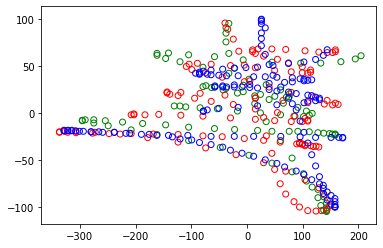

In [190]:
file = normalizeFile(file)
file3 = normalizeFile(file3)
file_fake = normalizeFile(file_fake)


#整理后的两张图片对比 comparison of graphics before and after normalizaiton
fig = plt.figure(figsize=[6,4])
plt.scatter(x = file["normalY"], y = file["normalX"], marker='o',c='', edgecolors='g')
plt.scatter(x= file3['normalY'], y= file3['normalX'] , marker='o',c='', edgecolors='r')
plt.scatter(x= file_fake['normalY'], y= file_fake['normalX'] , marker='o',c='', edgecolors='b')

fig.show()


In [191]:
# # 求两直线夹角
# def get_angle_betw_lines(x1, y1, x2, y2, x3, y3, x4, y4):
#     k1 = (y2-y1)/(float(x2-x1))
#     k2 = (y4-y3)/(float(x4-x3))
#     Cobb = math.fabs(np.arctan((k1-k2)/(float(1 + k1*k2)))*180/np.pi)+0.5
#     return Cobb

# def get_grivity_angle(P):
#     points_left = []
#     points_right = []
#     for point in P.exterior.coords:
#         if point[0] <= P.centroid.x:
#             points_left.append([point[0], point[1]])
#         else:
#             points_right.append([point[0], point[1]])

#     P_left = Polygon(points_left)
#     P_right = Polygon(points_right)        
# #     plt.plot(P_left.centroid.y, P_left.centroid.x, 'bx')
# #     plt.plot(P_right.centroid.y, P_right.centroid.x, 'bx')

#     theta = get_angle_betw_lines( P_left.centroid.x,  P_left.centroid.y,  P_right.centroid.x,  P_right.centroid.y,      
#                                  0,0, 10,0)
#     return theta


# #rotate for Polygon
# def rotate_polygon(polygon, angle, center_point=(0, 0)):
#     """Rotates the given polygon which consists of corners represented as (x,y)
#     around center_point (origin by default)
#     Rotation is counter-clockwise
#     Angle is in degrees
#     """
#     rotated_polygon = []
#     for corner in polygon.exterior.coords:
#         rotated_corner = rotate_point(corner, angle, center_point)
#         rotated_polygon.append(rotated_corner)
#     rotated_polygon = Polygon(rotated_polygon)    
#     return rotated_polygon

# def rotate_point(point, angle, center_point=(0, 0)):
#     """Rotates a point around center_point(origin by default)
#     Angle is in degrees.
#     Rotation is counter-clockwise
#     """
#     angle_rad = radians(angle % 360)
#     # Shift the point so that center_point becomes the origin
#     new_point = (point[0] - center_point[0], point[1] - center_point[1])
#     new_point = (new_point[0] * cos(angle_rad) - new_point[1] * sin(angle_rad),
#                  new_point[0] * sin(angle_rad) + new_point[1] * cos(angle_rad))
#     # Reverse the shifting we have done
#     new_point = (new_point[0] + center_point[0], new_point[1] + center_point[1])
#     return new_point



# # gravity_x, gravity_y = gravity_normalize(file)
# # print(gravity_x, gravity_y)

# from shapely.geometry import Polygon

# def rotate_graphic(file):
#     points_left = []
#     points_right = []
#     points = []

#     for index, row in file.iterrows():
#         points.append([row['normalX'], row['normalY']])

#     P = Polygon(points)
#     print(P.centroid)


# #     for index, row in file.iterrows():
# #         if row['normalX'] <= P.centroid.x:
# #             points_left.append([row['normalX'], row['normalY']])
# #         else:
# #             points_right.append([row['normalX'], row['normalY']])

# #     P_left = Polygon(points_left)
# #     P_right = Polygon(points_right)
# #     #print(P_left.centroid, P_right.centroid)

# #     theta = get_angle_betw_lines( P_left.centroid.x,  P_left.centroid.y,  P_right.centroid.x,  P_right.centroid.y,           
# #                                  0,0, 10,0)
#     theta = get_grivity_angle(P)
#     theta_old = theta
#     print(theta)
    
    
#     if theta >6 and get_grivity_angle(rotate_polygon(P, theta_old/24, (P.centroid.x, P.centroid.y))) < theta: 
#         while theta > 6.0 :
# #             print("here")
#     #     if theta <= 90: # clock-wise 顺时针
#             P = rotate_polygon(P, theta_old/24, (P.centroid.x, P.centroid.y))        
#             theta = get_grivity_angle(P)
#     elif  theta >6 and get_grivity_angle(rotate_polygon(P, -theta_old/24, (P.centroid.x, P.centroid.y))) < theta_old:
#         while theta > 6.0 :
#             P = rotate_polygon(P, -theta_old/24, (P.centroid.x, P.centroid.y))        
#             theta = get_grivity_angle(P)          
            
#     P_rotated = P
#     P_rotated_points_x = []
#     P_rotated_points_y = []
#     for point in   P_rotated.exterior.coords:
#         P_rotated_points_x.append(point[0])   
#         P_rotated_points_y.append(point[1])   

#     print(P_rotated.centroid)




#     fig = plt.figure(figsize=[6,4])
#     plt.scatter(x = file["normalY"], y = file["normalX"], marker='o',c='', edgecolors='g')

# #     plt.plot(gravity_y, gravity_x, 'rx')
# #     plt.plot(P_left.centroid.y, P_left.centroid.x, 'rx')
# #     plt.plot(P_right.centroid.y, P_right.centroid.x, 'rx')

#     plt.scatter(x = P_rotated_points_y, y = P_rotated_points_x, marker='o',c='', edgecolors='b')

#     points_left = []
#     points_right = []
#     for point in P_rotated.exterior.coords:
#         if point[0] <= P_rotated.centroid.x:
#             points_left.append([point[0], point[1]])
#         else:
#             points_right.append([point[0], point[1]])

#     P_left = Polygon(points_left)
#     P_right = Polygon(points_right)        
#     plt.plot(P_left.centroid.y, P_left.centroid.x, 'bx')
#     plt.plot(P_right.centroid.y, P_right.centroid.x, 'bx')

#     theta = get_angle_betw_lines( P_left.centroid.x,  P_left.centroid.y,  P_right.centroid.x,  P_right.centroid.y,      
#                                  0,0, 10,0)
#     print(theta)
#     # plt.plot(gravity_x, gravity_y, 'bx')


#     fig.show()

#     file['normalX'] = P_rotated_points_x[0:-1]
#     file['normalY'] = P_rotated_points_y[0:-1]
#     return file

# file = rotate_graphic(file)
# file3 = rotate_graphic(file3)



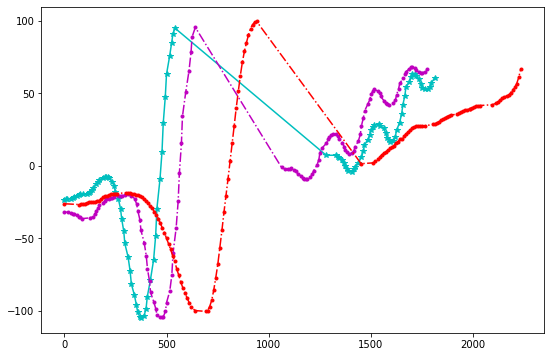

In [192]:
#the plot before length normalization
fig = plt.figure(figsize=[9,6])
plt.plot(file["TStamp2"], file["normalX"],'c*-', )
plt.plot(file3['TStamp2'], file3['normalX'] , 'm.-.')
plt.plot(file_fake['TStamp2'], file_fake['normalX'] , 'r.-.')
#we can see clearly, the length of two plots are not same

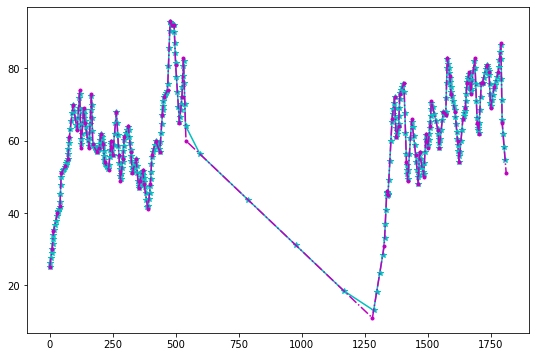

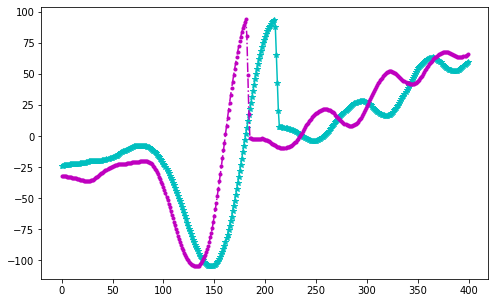

In [193]:
def samelen(data,length=400):
#归一化标准长度为 400，若某一签名长度为 d，则需在此签名中每隔
#(d-1)/400 个坐标点提取一个数据， 所取得的数据根据前后两个点进行线性提取
#assume the normalized standard length is 400. If the total signature length is d, 
#you need to extract one data every (d-1)/400 length in this signature, 
#and the obtained data will be linearly extracted based on the two adjacent points before and after.
    data_size = len(data)
    interval = (data_size-1)/length
    start = 0
    new_data = data.drop(index=data.index)
    for dist in np.arange(start, data_size-1, interval):
        first = math.floor(dist)
        second = math.ceil(dist)
        if second >= data_size:
            second = data_size -1
        percent = (dist - first) / 1.0   
        #'X','Y','TStamp','Pres','EndPts'
#         print ((data.X[first] + data.X[second])/2)

#         X = (data.at[first,'X'] + data.at[second,'X']) / 2
#         Y = (data.Y[first] + data.Y[second])/2 
        TStamp = (data.TStamp[first] + data.TStamp[second])/2 
#         Pres = (data.Pres[first] + data.Pres[second])/2
#         normalX = (data.normalX[first] + data.normalX[second])/2
#         normalY = (data.normalY[first] + data.normalY[second])/2 
#         TStamp2 = (data.TStamp2[first] + data.TStamp2[second])/2
        
        X = data.at[first,'X'] + (data.at[second,'X'] - data.at[first,'X']) * percent
        Y = data.at[first,'Y'] + (data.at[second,'Y'] - data.at[first,'Y']) * percent
        normalX = data.at[first,'normalX'] + (data.at[second,'normalX'] - data.at[first,'normalX']) * percent
        normalY = data.at[first,'normalY'] + (data.at[second,'normalY'] - data.at[first,'normalY']) * percent 
        TStamp2 = data.at[first,'TStamp2'] + (data.at[second,'TStamp2'] - data.at[first,'TStamp2']) * percent 
        Pres = data.at[first,'Pres'] + (data.at[second,'Pres'] - data.at[first,'Pres']) * percent 
        Angle = data.at[first,'Angle'] + (data.at[second,'Angle'] - data.at[first,'Angle']) * percent
        Vel = data.at[first,'Vel'] + (data.at[second,'Vel'] - data.at[first,'Vel']) * percent 
        Logcr = data.at[first,'Logcr'] + (data.at[second,'Logcr'] - data.at[first,'Logcr']) * percent 
        Tam = data.at[first,'Tam'] + (data.at[second,'Tam'] - data.at[first,'Tam']) * percent 
              
        if data.EndPts[first] == 1 or data.EndPts[second] == 1:
            EndPts = 1
        else:
            EndPts = 0
            
        new_data.loc[len(new_data)] = {'X': X, 'Y': Y, 'TStamp': TStamp, 'Pres': Pres, 'EndPts': EndPts,'normalX': normalX,
                         'normalY': normalY, 'TStamp2': TStamp2,'Angle': Angle,'Vel': Vel,'Logcr': Logcr,'Tam': Tam }
    return new_data

#         d = (data[first] + data[second])/2
#         new_data.loc[len(new_data)] = d

data1 = file
data2 = file3
data3 = file_fake

length = max([len(file),len(file3),len(file_fake)])

length = 400
data1 = samelen(file,length)
data2 = samelen(file3,length)
data3 = samelen(file_fake,length)

# print(data1['Pres'])
# print(file['Pres'])

fig = plt.figure(figsize=[9,6])
plt.plot(data1["TStamp2"], data1["Pres"],'c*-', )
plt.plot(file['TStamp2'], file['Pres'] , 'm.-.')
fig.show()
# print(file)
# print(data1)
# df = file        
# df=df.drop(index=df.index)
# file.loc[len(file)] = 3

# print (list(range(0,len(data1)-1, 1)))
#the plot after length normalization
fig = plt.figure(figsize=[8,5])
# plt.plot(data1["TStamp2"], data1["normalX"],'c*-', )
# plt.plot(data2['TStamp2'], data2['normalX'] , 'm.-.')
plt.plot( list(range(0,len(data1), 1)), data1["normalX"],'c*-')
plt.plot( list(range(0,len(data2),1)), data2['normalX'] , 'm.-.')
# plt.plot( list(range(0,len(data3),1)), data3['normalX'] , 'r.-.')
#we can see clearly, the length of two plots are same

1676.8749999999993
2009.4800000000023


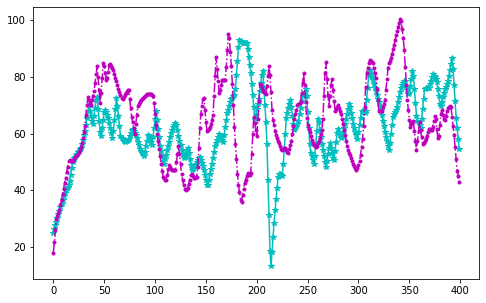

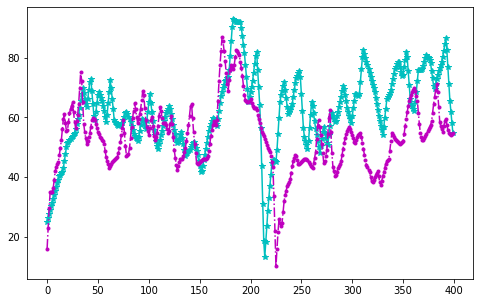

In [194]:
#set ts_a
# X = np.array(data1['X'])
# Y = np.array(data1['Y'])
Pres = np.array(data1['Pres'])
# list(zip(X,Y,Pres))
ts_a = np.array(list(zip(Pres)),dtype=float)

#set ts_b
# X = np.array(data2['X'])
# Y = np.array(data2['Y'])
Pres = np.array(data2['Pres'])
# list(zip(X,Y,Pres))
ts_b = np.array(list(zip(Pres)),dtype=float)

#set ts_c
# X = np.array(data2['X'])
# Y = np.array(data2['Y'])
Pres = np.array(data3['Pres'])
# list(zip(X,Y,Pres))
ts_c = np.array(list(zip(Pres)),dtype=float)

# re = dtw_distance(ts_a, ts_b)
# re2 = dtw_distance(ts_a, ts_c)
re = fastdtw(ts_a, ts_b, dist=euclidean)
re2 = fastdtw(ts_a, ts_c, dist=euclidean)

print(re[0])
print(re2[0])
fig = plt.figure(figsize=[8,5])
plt.plot( list(range(0,len(data1), 1)), data1["Pres"],'c*-')
plt.plot( list(range(0,len(data2),1)), data2['Pres'] , 'm.-.')
fig.show()

fig = plt.figure(figsize=[8,5])
plt.plot( list(range(0,len(data1), 1)), data1["Pres"],'c*-')
plt.plot( list(range(0,len(data3),1)), data3['Pres'] , 'm.-.')
fig.show()

In [195]:
#set ts_a
X = np.array(data1['normalX'])
Y = np.array(data1['normalY'])
# Pres = np.array(data1['Pres'])
# list(zip(X,Y,Pres))
ts_a = np.array(list(zip(X,Y)),dtype=float)

#set ts_b
X = np.array(data2['normalX'])
Y = np.array(data2['normalY'])
# Pres = np.array(data2['Pres'])
# list(zip(X,Y,Pres))
ts_b = np.array(list(zip(X,Y)),dtype=float)

#set ts_c
X = np.array(data2['normalX'])
Y = np.array(data2['normalY'])
# Pres = np.array(data3['Pres'])
# list(zip(X,Y,Pres))
ts_c = np.array(list(zip(X,Y)),dtype=float)

re = dtw_distance(ts_a, ts_b)
re2 = dtw_distance(ts_a, ts_c)

print(re)

6404894.4126896085


12 15
[0, 32, 38, 74, 147, 209, 248, 295, 319, 365, 385, 399]
[0, 25, 80, 132, 181, 188, 197, 216, 259, 283, 323, 344, 376, 391, 399]


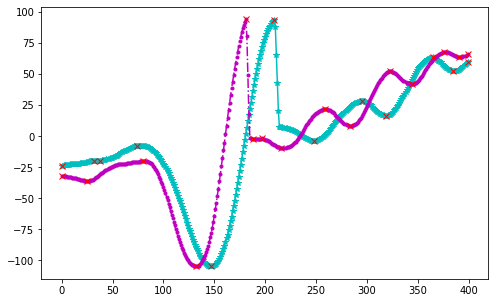

In [196]:

def calc_extrme_points(data):
    length=len(data)
    data_extr_points ={}
    data_extr_points['point'] = []
    data_extr_points['value'] = []    
    data_extr_points['type'] = []    
    
    for i in range(5,length-5):
        # local maximum point
        local_list = list(range(i-5, i)) 
        #如果之前5个点之内已经记录有点，则不记录
        #If a point has been recorded within 5 points before, it will not be recorded
        if data[i]>=data[i-1] and data[i]>=data[i-2] and data[i]>=data[i-3] and data[i]>=data[i-4] and data[i]>=data[i-5] and \
        data[i]>=data[i+1] and data[i]>=data[i+2] and data[i]>=data[i+3] and data[i]>=data[i+4] and data[i]>=data[i+5] and \
        len([j for j in local_list if j in data_extr_points['point'] ]) == 0:
            data_extr_points['point'].append(i)
            data_extr_points['value'].append(data[i])
            data_extr_points['type'].append(1)
            continue
            
        # local minimum point            
        if data[i]<=data[i-1] and data[i]<=data[i-2] and data[i]<=data[i-3] and data[i]<=data[i-4] and data[i]<=data[i-5] and \
        data[i]<=data[i+1] and data[i]<=data[i+2] and data[i]<=data[i+3] and data[i]<=data[i+4] and data[i]<=data[i+5] and \
        len([j for j in local_list if j in data_extr_points['point'] ]) == 0:
            data_extr_points['point'].append(i)
            data_extr_points['value'].append(data[i])
            data_extr_points['type'].append(0)
        
    #add start,end point
    if data_extr_points['type'][0] == 0:
        start_type = 1
    else:
        start_type = 0
    data_extr_points['point'].insert(0, 0)
    data_extr_points['value'].insert(0, data[0])
    data_extr_points['type'].insert(0, start_type)

    if data_extr_points['type'][-1] == 0:
        end_type = 1
    else:
        end_type = 0
    data_extr_points['point'].append(length-1)
    data_extr_points['value'].append(data[length-1])
    data_extr_points['type'].append(end_type)        
    
    return data_extr_points

data1_extr_points = calc_extrme_points(data1['normalX'].tolist())
data2_extr_points = calc_extrme_points(data2['normalX'].tolist())

print(len(data1_extr_points['point']), len(data2_extr_points['point']))

print(data1_extr_points['point'])
print(data2_extr_points['point'])

fig = plt.figure(figsize=[8,5])

plt.plot( list(range(0,len(data1), 1)), data1["normalX"],'c*-')
plt.plot( list(range(0,len(data2),1)), data2['normalX'] , 'm.-.')
plt.plot( data1_extr_points['point'], data1_extr_points['value'],'rx')
plt.plot( data2_extr_points['point'], data2_extr_points['value'],'rx')

In [197]:
# calculate dtw distance by strokes
def get_stroke(df, extr_points, index):
    start = extr_points['point'][index]
    end = extr_points['point'][index+1]
    df_new = df.loc[start:end].copy()
#     print(df)
#     print(df_new)
#     df_new = normalizeFile(df_new)
    
    #set ts_a
    normalX = np.array(df_new['normalX'])
    normalY = np.array(df_new['normalY'])
    list(zip(normalX,normalY))
    ts_a = np.array(list(zip(normalX,normalY)),dtype=float)
        
    return ts_a, df_new


total_distance = 0.0
print(len(data1_extr_points['point']), len(data2_extr_points['point']))
if len(data1_extr_points['point']) == len(data2_extr_points['point']):
    i = 0
    while i< len(data1_extr_points['point']) -1:
        ts_a, df_stroke1 = get_stroke(data1, data1_extr_points, i)
        ts_b, df_stroke2 = get_stroke(data2, data2_extr_points, i)

        fig = plt.figure(figsize=[8,5])
        # plt.plot(data1["TStamp2"], data1["normalX"],'c*-', )
        # plt.plot(data2['TStamp2'], data2['normalX'] , 'm.-.')
        plt.plot( list(range(0,len(df_stroke1),1)),df_stroke1["normalX"],'c*-')
        plt.plot( list(range(0,len(df_stroke2),1)),df_stroke2['normalX'],'m.-.')
        fig.show()
        distance, path = fastdtw(ts_a, ts_b, dist=euclidean)
        total_distance += distance
#         break
        i +=1
print("DTW distance by stroke: ", total_distance)
        

12 15
DTW distance by stroke:  0.0


In [198]:
# def cal_acceleration(df):
#     acce_arr = []
#     for index, row in df.iterrows():
#         if index == len(df) - 1:
#             acce = 0
#         else:    
#             dy = df['Y'][index + 1] - row['Y']
#             dx = df['X'][index + 1] - row['X']
#         acce_arr.append(acce)    
#         break

        
# def addSigFeature(df):
#     dX = derivation(df['X'].tolist())     # dx
#     dY = derivation(df['Y'].tolist())     # dy
# #     df['dX'] = dX
# #     df['dY'] = dY
#     Vel = np.zeros(len(df)).tolist()   # velocity
#     Angle = np.zeros(len(df)) # angle
    
    
#     T = len(df) -1
#     t = 1
#     while t<= T:
#         Vel[t] = math.sqrt(dX[t] * dX[t] + dY[t] * dY[t])
#         if dY[t] != 0 and dX[t] != 0:
#             Angle[t] = math.atan(dY[t] / dX[t])
#         elif dX[t] == 0:
#             Angle[t] = math.atan(dY[t] / 0.0001)
#         else:
#             Angle[t] = 0
#         t += 1    
#     dAngle = derivation(Angle)
#     dVel = derivation(Vel)
#     Logcr = np.zeros(len(df)).tolist() 
#     Tam = np.zeros(len(df)).tolist() #加速度
    
#     t = 1
#     while t<= T:
#         Logcr[t] = math.log((abs(Vel[t]) + 0.01) / ((abs(dAngle[t]) + 0.01))) ;
#         Tam[t] = math.sqrt(dVel[t] * dVel[t] + Vel[t] * Vel[t] * dAngle[t] * dAngle[t]) ;
#         t += 1
#     df['Angle'] = Angle
#     df['Vel'] = Vel
#     df['Logcr'] = Logcr
#     df['Tam'] = Tam
#     return df
    

    
# # calculate the difference of the discrete sequence    
# def derivation(signal):
#     T = len(signal)-1
#     dsignal = np.zeros(len(signal)).tolist()
#     dsignal[0] = (2*signal[2] + signal[1] - 3*signal[0]) / 5
#     dsignal[1] = (2*signal[3] + signal[2] - 2*signal[1] - signal[0]) / 6
#     t= 2
#     while t<=T-2:
#         dsignal[t] = (2*signal[t+2] + signal[t+1] - signal[t-1] - 2*signal[t-2]) / 10 
# #         print(dsignal[t])        
#         t += 1
#         # (2(Xn+2)+(Xn+1)-(Xn-1)-2(Xn-2))/10 == [2(Xn+2)-2(Xn+1)+3(Xn+1)-3(Xn)+3(Xn)-3(Xn-1)+2(Xn-1)-2(Xn-2)]/10
        
#     dsignal[T-1] = (signal[T] - signal[T-2] + 2*signal[T-1] - 2*signal[T-3]) / 6 
#     dsignal[T] = (3*signal[T] - signal[T-1] - 2*signal[T-2]) / 5 
#     return dsignal
    
# # X = Sig(:, 1) ;
# # Y = Sig(:, 2) ;
# # if pflag
# #     P = Sig(:, 3);
# # end
# # T = length(Sig) ;

# # % get the velocity\angle\curvature\full acceleration\coordinates\pressure
# # dX = Derivation(X);     % dx
# # dY = Derivation(Y);     % dy
# # Vel = zeros(size(X));   % velocity
# # Angle = zeros(size(X)); % angle
# # for t = 1 : T
# #     Vel(t) = sqrt(dX(t) * dX(t) + dY(t) * dY(t)) ;
# #     if dY(t) ~= 0
# #         Angle(t) = atan(dY(t) / dX(t)) ;
# #     else
# #         Angle(t) = 0 ;
# #     end
# # end
# # dAngle = Derivation(Angle) ;
# # dVel = Derivation(Vel) ;
# # Logcr = zeros(size(X)) ;
# # Tam = zeros(size(X)) ;
# # for t = 1 : T
# #     Logcr(t) = log((abs(Vel(t)) + 0.01) / ((abs(dAngle(t)) + 0.01))) ;
# #     Tam(t) = sqrt(dVel(t) * dVel(t) + Vel(t) * Vel(t) * dAngle(t) * dAngle(t)) ;
# # end
# # if pflag
# #     Feature = [X, Y, P, Angle, Vel, Tam, Logcr] ;
# # else
# #     Feature = [X, Y, Angle, Vel, Tam, Logcr] ;
# # end

# # % signal normalization
# # Feature = zscore(Feature);
# # end


# data1 = addSigFeature(data1)   
# data2 = addSigFeature(data2)   
# data3 = addSigFeature(data3)   

genuine signature distance:  10907.16870757331
forgery signature distance:  12967.828284910833


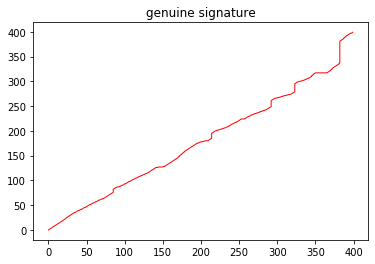

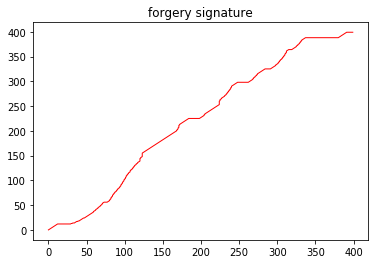

In [199]:


#set ts_a
normalX = np.array(data1['normalX'])
normalY = np.array(data1['normalY'])
list(zip(normalX,normalY))
ts_a = np.array(list(zip(normalX,normalY)),dtype=float)
# print(normalX)

#set ts_b
normalX = np.array(data2['normalX'])
normalY = np.array(data2['normalY'])
list(zip(normalX,normalY))
ts_b = np.array(list(zip(normalX,normalY)),dtype=float)

#set ts_c
normalX = np.array(data3['normalX'])
normalY = np.array(data3['normalY'])
list(zip(normalX,normalY))
ts_c = np.array(list(zip(normalX,normalY)),dtype=float)


#the plot of DTW distance for genuine signature
distance, path = fastdtw(ts_a, ts_b, dist=euclidean)
print("genuine signature distance: ", distance)
# print(path)
path = list(path)
xpath = []
ypath = []
for v in path:
    xpath.append(v[0])
    ypath.append(v[1])

fig = plt.figure(figsize=[6,4])
plt.plot(xpath, ypath, color="r",linewidth=1 )
plt.title("genuine signature")
fig.show()
#we can see clearly, the plot is smooth


#the plot of DTW distance for forgery signature
distance, path = fastdtw(ts_b, ts_c, dist=euclidean)
print("forgery signature distance: ", distance)
# print(path)
path = list(path)
xpath = []
ypath = []
for v in path:
    xpath.append(v[0])
    ypath.append(v[1])
fig = plt.figure(figsize=[6,4])
plt.plot(xpath, ypath,color="r",linewidth=1 )
plt.title("forgery signature")
fig.show()
#we can see clearly, the plot is not smooth


2.0538485988446187
genuine signature distance:  290.9946936495268
forgery signature distance:  337.5913690866984


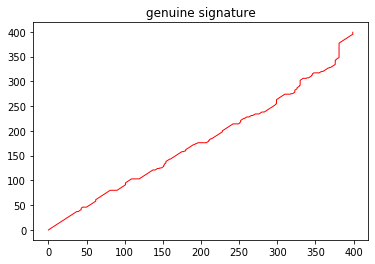

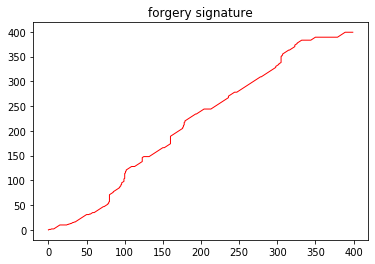

In [205]:
def normalization_df(df):
    normalized_df=(df-df.mean())/df.std()
#     normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

data1 = normalization_df(data1)
data2 = normalization_df(data2)
data3 = normalization_df(data3)

print(max(data1['normalX'].tolist()))
#set ts_a
normalX = np.array(data1['normalX'])
normalY = np.array(data1['normalY'])
Pres = np.array(data1['Pres'])
Angle = np.array(data1['Angle'])
Vel = np.array(data1['Vel'])
Logcr = np.array(data1['Logcr'])
Tam = np.array(data1['Tam'])

list(zip(normalX,normalY))
# ts_a = np.array(list(zip(normalX,normalY,Angle,Vel,Logcr,Tam)),dtype=float)
ts_a = np.array(list(zip(normalX,normalY,Pres)),dtype=float)

# print(normalX)

#set ts_b
normalX = np.array(data2['normalX'])
normalY = np.array(data2['normalY'])
Pres = np.array(data2['Pres'])
Angle = np.array(data2['Angle'])
Vel = np.array(data2['Vel'])
Logcr = np.array(data2['Logcr'])
Tam = np.array(data2['Tam'])
list(zip(normalX,normalY))
# ts_b = np.array(list(zip(normalX,normalY,Angle,Vel,Logcr,Tam)),dtype=float)
ts_b = np.array(list(zip(normalX,normalY,Pres)),dtype=float)


#set ts_c
normalX = np.array(data3['normalX'])
normalY = np.array(data3['normalY'])
Pres = np.array(data3['Pres'])
Angle = np.array(data3['Angle'])
Vel = np.array(data3['Vel'])
Logcr = np.array(data3['Logcr'])
Tam = np.array(data3['Tam'])
list(zip(normalX,normalY))
# ts_c = np.array(list(zip(normalX,normalY,Angle,Vel,Logcr,Tam)),dtype=float)
ts_c = np.array(list(zip(normalX,normalY,Pres)),dtype=float)


#the plot of DTW distance for genuine signature
distance, path = fastdtw(ts_a, ts_b, dist=euclidean)
print("genuine signature distance: ", distance)
# print(path)
path = list(path)
xpath = []
ypath = []
for v in path:
    xpath.append(v[0])
    ypath.append(v[1])

fig = plt.figure(figsize=[6,4])
plt.plot(xpath, ypath, color="r",linewidth=1 )
plt.title("genuine signature")
fig.show()
#we can see clearly, the plot is smooth


#the plot of DTW distance for forgery signature
distance, path = fastdtw(ts_b, ts_c, dist=euclidean)
print("forgery signature distance: ", distance)
# print(path)
path = list(path)
xpath = []
ypath = []
for v in path:
    xpath.append(v[0])
    ypath.append(v[1])
fig = plt.figure(figsize=[6,4])
plt.plot(xpath, ypath,color="r",linewidth=1 )
plt.title("forgery signature")
fig.show()
#we can see clearly, the plot is not smooth
